## Entanglement entropy and Participation Ratio

I have to add case with N disorder > 1

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import pickle

import sys
from pathlib import Path

PROJECT_ROOT = str(Path.cwd().parent.resolve())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import Class_site as site
import free_fermion_representation as f
import variables_phasediagram_simulation as vps

import importlib

importlib.reload(site)
importlib.reload(f)
importlib.reload(vps)

<module 'variables_phasediagram_simulation' from '/Users/giovanniconcheri/Desktop/TESI/MasterThesis/variables_phasediagram_simulation.py'>

In [54]:
model = site.SitesOBC(Npx = 21, Npy = 21, edge = True)
fgs = f.FermionicGaussianRepresentation(model)

In [55]:
def quantities_delta_T(model, fgs, T, delta, N_cycles, edgepar = None, loop_type = 'general', loop_list = None):

    fgs.reset_cov_0_matrix()
    fgs.reset_cov_e_matrix()

    _, _, _, R0 = fgs.floquet_operator_ham(T)
    _, _, _, Re = fgs.floquet_operator_ham(T, anyon=True)
    
    if delta != 0:
        V0 = f.generate_disorder_term(model, fgs.Cov, delta, edgepar = edgepar)
        Ve = f.generate_disorder_term(model, fgs.Cov, delta, type="Anyon", edgepar = edgepar)
        R_V0 = f.floquet_operator(V0, T, alpha = np.pi/4.)
        R_Ve = f.floquet_operator(Ve, T, alpha = np.pi/4.)
        R_V0_R0 = R_V0 @ R0
        R_Ve_Re = R_Ve @ Re
    else:
        R_V0_R0 = R0
        R_Ve_Re = Re

    entropy_0 = []
    entropy_e = []
    entropy_0_half = []
    entropy_e_half = []
    entropy_0_bulk = []
    entropy_e_bulk = []

    pr_0 = []
    pr_e = []

    for _ in range(N_cycles):
        entropy_0.append(fgs.ent_entropy_partition(e = False, partition = None))
        entropy_e.append(fgs.ent_entropy_partition(e = True, partition = None))
        entropy_0_half.append(fgs.ent_entropy_partition(e = False, partition = 'half'))
        entropy_e_half.append(fgs.ent_entropy_partition(e = True, partition = 'half'))
        entropy_0_bulk.append(fgs.ent_entropy_partition(e = False, partition = 'bulk'))
        entropy_e_bulk.append(fgs.ent_entropy_partition(e = True, partition = 'bulk'))

        pr_0.append(fgs.participation_ratio(e = False))
        pr_e.append(fgs.participation_ratio(e=True))

        fgs.update_cov_0_matrix(R_V0_R0)
        fgs.update_cov_e_matrix(R_Ve_Re)

    entropy_0.append(fgs.ent_entropy_partition(e = False, partition = None))
    entropy_e.append(fgs.ent_entropy_partition(e = True, partition = None))
    entropy_0_half.append(fgs.ent_entropy_partition(e = False, partition = 'half'))
    entropy_e_half.append(fgs.ent_entropy_partition(e = True, partition = 'half'))
    entropy_0_bulk.append(fgs.ent_entropy_partition(e = False, partition = 'bulk'))
    entropy_e_bulk.append(fgs.ent_entropy_partition(e = True, partition = 'bulk'))

    pr_0.append(fgs.participation_ratio(e = False))
    pr_e.append(fgs.participation_ratio(e=True))

    return {
        'entropy_0': entropy_0,
        'entropy_e': entropy_e,
        'entropy_0_half': entropy_0_half,
        'entropy_e_half': entropy_e_half,
        'entropy_0_bulk': entropy_0_bulk,
        'entropy_e_bulk': entropy_e_bulk,
        'pr_0': pr_0,
        'pr_e': pr_e
    }

In [56]:
def entropy_and_pr(delta_list, T_list, model, fgs, N_cycles, save_dir=None):
    results = np.empty((len(delta_list), len(T_list)), dtype=object)
    for i, delta in enumerate(tqdm(delta_list, desc="Delta loop")):
        for j, T in enumerate(tqdm(T_list, desc="T loop", leave=False)):
            result = quantities_delta_T(model, fgs, T, delta, N_cycles)
            results[i, j] = result
            
    if save_dir:
        general_dir = 'entropy_and_pr_results'
        full_dir = os.path.join(general_dir, save_dir)
        os.makedirs(full_dir, exist_ok=True)
        with open(os.path.join(full_dir, 'results.pkl'), 'wb') as ffile:
            pickle.dump(results, ffile)

    return results


## Check

full covariance matrix should yield entanglement entropy = 0, which we find

In [57]:
fgs.ent_entropy_partition(e = True, partition = None)

np.float64(0.0)

In [58]:
delta_list = vps.delta_list_1
T_list = vps.T_list_0

In [60]:
results = entropy_and_pr(delta_list, T_list, model = model, fgs = fgs, N_cycles = 10, save_dir = 'size21_delta_list_1_T_list_0')

Delta loop:   0%|          | 0/6 [00:00<?, ?it/s]

T loop:   0%|          | 0/10 [00:00<?, ?it/s]

T loop:   0%|          | 0/10 [00:00<?, ?it/s]

T loop:   0%|          | 0/10 [00:00<?, ?it/s]

T loop:   0%|          | 0/10 [00:00<?, ?it/s]

T loop:   0%|          | 0/10 [00:00<?, ?it/s]

T loop:   0%|          | 0/10 [00:00<?, ?it/s]

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def plot_quantity_vs_cycles(results, delta_list, T_list, 
                            i=None, j=None, 
                            delta=None, T=None, 
                            key='entropy_0', 
                            ax=None, color=None, color_1=None,
                            marker='o', linestyle='-', linewidth=1.5,
                            save_path=None, title=None):
    """
    Plot a selected quantity vs Floquet cycles for a fixed (delta, T).

    Parameters
    - results: np.ndarray (object), output of entropy_and_pr with cells being dicts of lists.
    - delta_list, T_list: arrays used to build 'results'.
    - i, j: integer indices into (delta_list, T_list). If not provided, 'delta' and 'T' will be used.
    - delta, T: float values to select nearest indices if i/j are None.
    - key: one of [
        'entropy_0','entropy_e',
        'entropy_0_half','entropy_e_half',
        'entropy_0_bulk','entropy_e_bulk',
        'pr_0','pr_e'
      ]
    - ax: optional matplotlib Axes to draw on. If None, a new figure/axes is created.
    - color, marker, linestyle, linewidth: styling options.
    - save_path: optional filepath to save the figure (PNG).
    - title: optional plot title.

    Returns
    - ax: the matplotlib Axes with the plot.
    """
    valid_keys = {
        'entropy_0': 'Entropy (no anyons) – full',
        'entropy_e': 'Entropy (e anyon) – full',
        'entropy_0_half': 'Entropy (no anyons) – half',
        'entropy_e_half': 'Entropy (e anyon) – half',
        'entropy_0_bulk': 'Entropy (no anyons) – bulk',
        'entropy_e_bulk': 'Entropy (e anyon) – bulk',
        'pr_0': 'Participation ratio (no anyons)',
        'pr_e': 'Participation ratio (e anyon)',
    }
    if key not in valid_keys:
        raise ValueError(f"key must be one of {list(valid_keys.keys())}, got {key}")

    # Resolve indices i, j (prefer explicit indices; otherwise pick nearest values)
    if i is None or j is None:
        if delta is None or T is None:
            raise ValueError("Provide either (i, j) or (delta, T).")
        d_arr = np.asarray(delta_list, dtype=float)
        t_arr = np.asarray(T_list, dtype=float)
        i = int(np.argmin(np.abs(d_arr - float(delta))))
        j = int(np.argmin(np.abs(t_arr - float(T))))
        delta = d_arr[i]
        T = t_arr[j]
    else:
        delta = float(delta_list[i])
        T = float(T_list[j])

    # Extract the series for the chosen cell/key
    cell = results[i, j]
    if not isinstance(cell, dict) or key not in cell:
        raise KeyError(f"Cell ({i},{j}) has no key '{key}'.")
    series = np.asarray(cell[key], dtype=float)

    own_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(5.5, 4.0))
        own_fig = True

    label = valid_keys[key]
    if key in ['entropy_0_half', 'entropy_e_half', 'entropy_0_bulk', 'entropy_e_bulk']:
        series_A = [i for i,_ in series]
        # series_B = [i for _,i in series]
        x = np.arange(len(series_A))  # cycle index (includes final value after last update)
        ax.plot(x, series_A, linestyle=linestyle, marker=marker, color=color, linewidth=linewidth, label=label)
        # ax.plot(x, series_B, linestyle=linestyle, marker=marker, color=color_1, linewidth=linewidth, label=label + ' (B)', alpha=0.7)
    else:
        x = np.arange(series.size)  # cycle index (includes final value after last update)
        ax.plot(x, series, linestyle=linestyle, marker=marker, color=color, linewidth=linewidth, label=label)
    ax.set_xlabel('Floquet cycles')
    ax.set_ylabel(key if 'pr' in key else 'Entanglement entropy')
    if title is None:
        title = f"{label}\nΔ={delta:.3g}, T={T:.3g} (N={series.size})"
    ax.set_title(title)
    ax.grid(alpha=0.25)
    # For single series, legend is optional; comment out if not desired
    ax.legend(frameon=False)

    if save_path:
        if own_fig:
            fig.tight_layout()
            fig.savefig(save_path, dpi=150)
        else:
            plt.gcf().tight_layout()
            plt.gcf().savefig(save_path, dpi=150)

    return ax

## Entropy 0: full cov matrix

/var/folders/6j/zg3nz4053f97fyqx4w2b6pxc0000gn/T/ipykernel_88605/1574514306.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(5.5, 4.0))


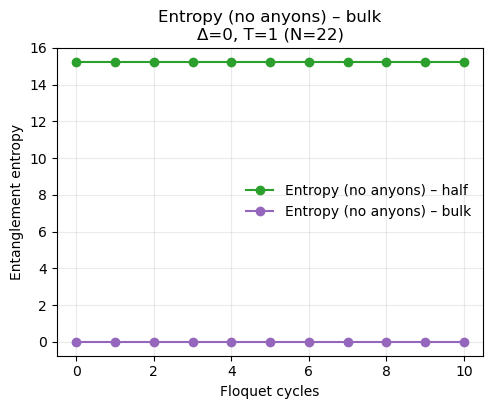

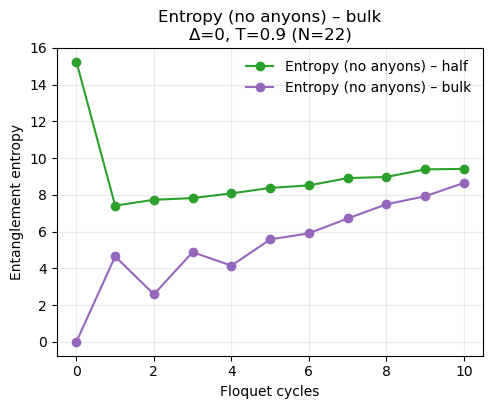

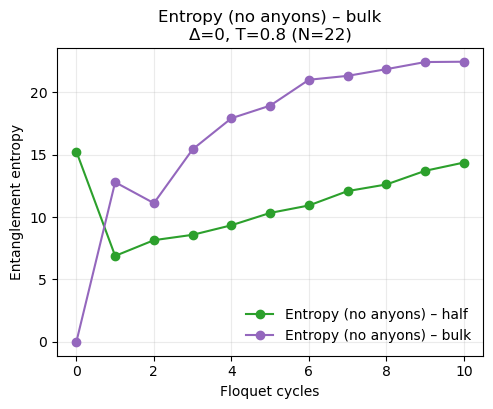

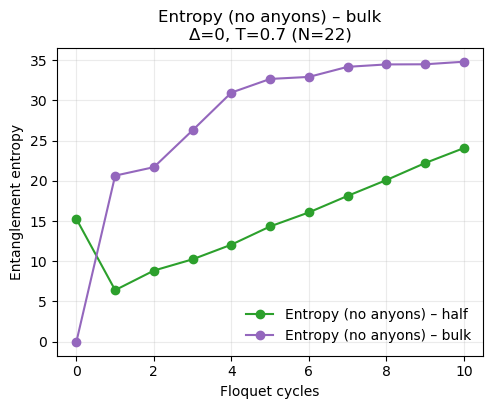

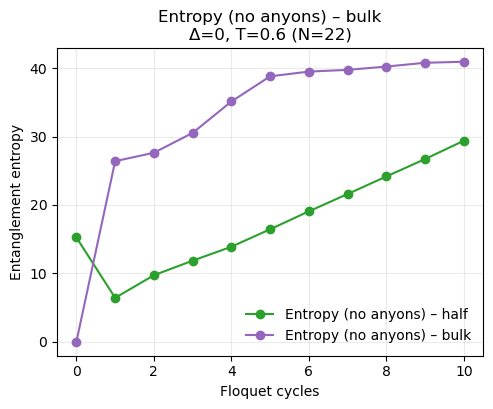

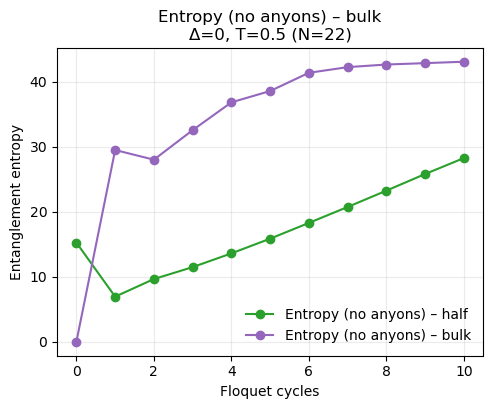

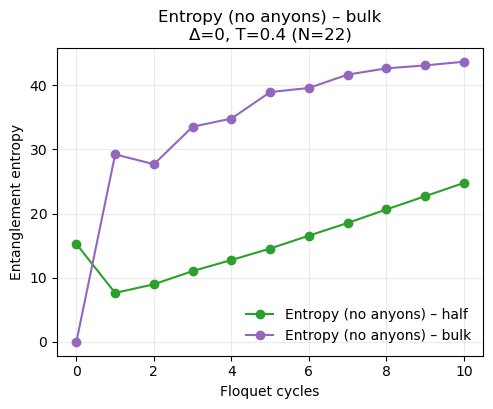

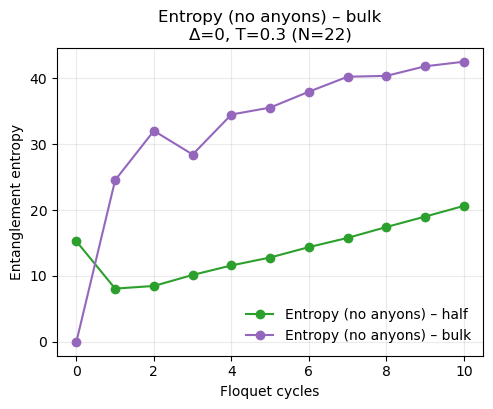

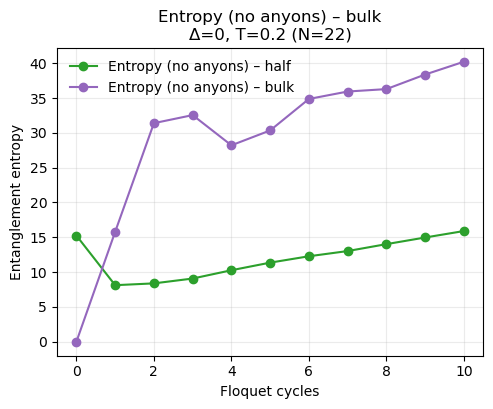

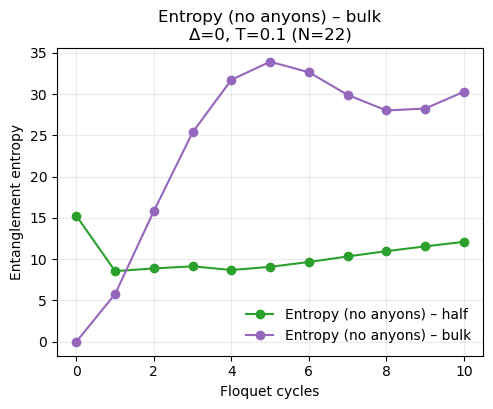

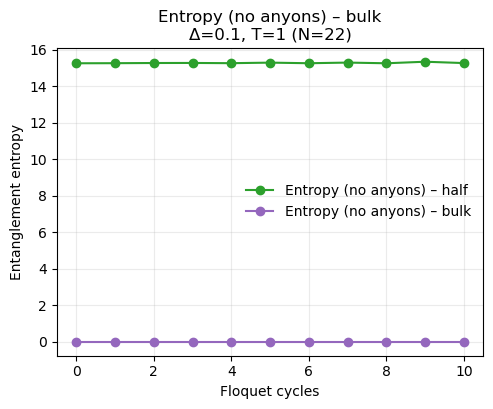

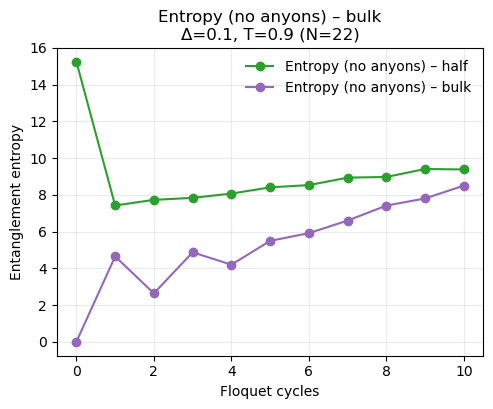

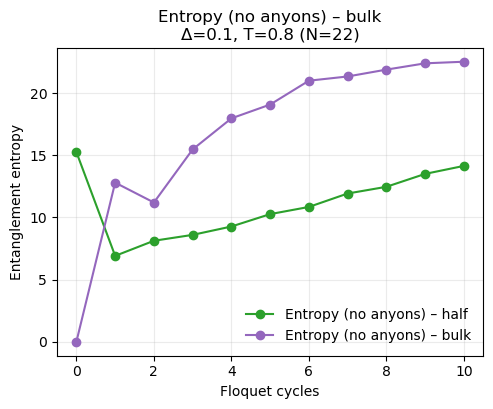

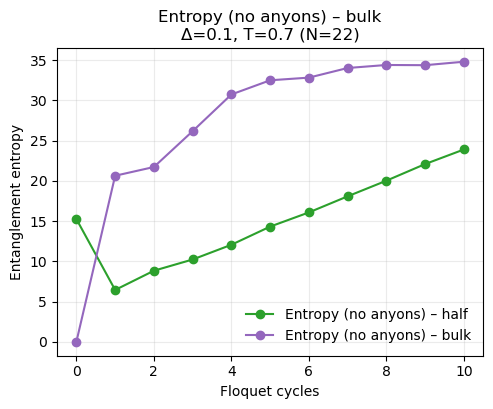

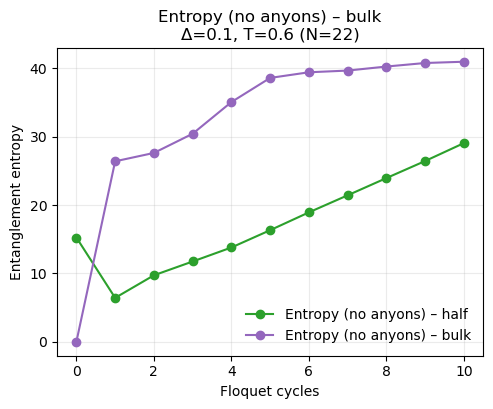

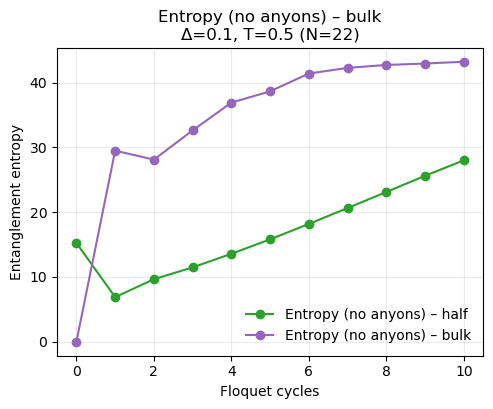

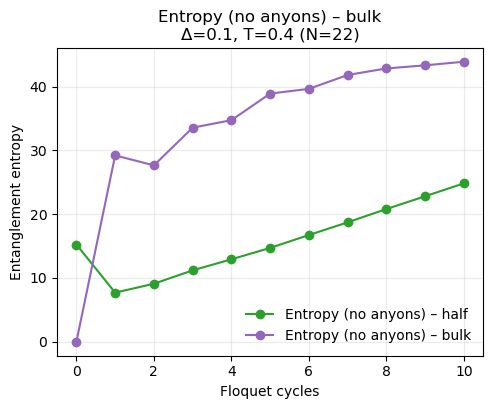

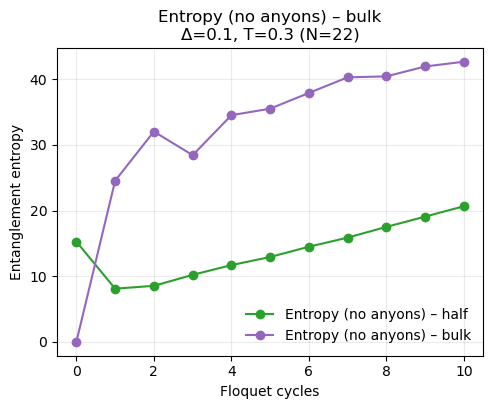

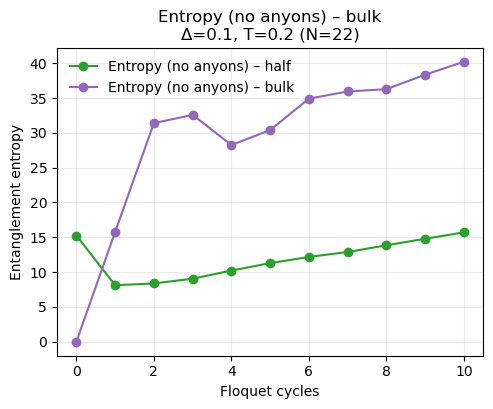

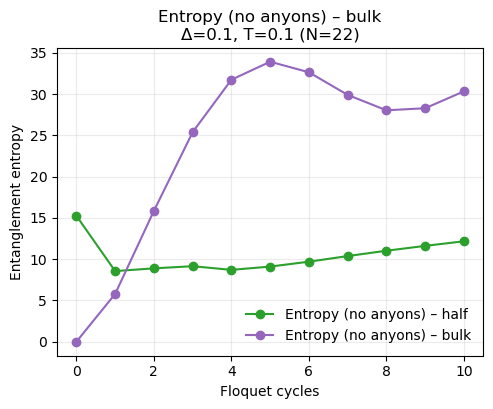

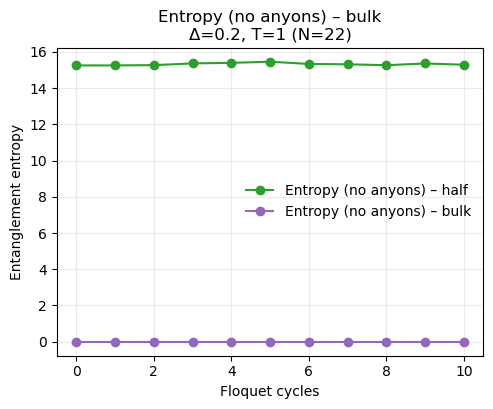

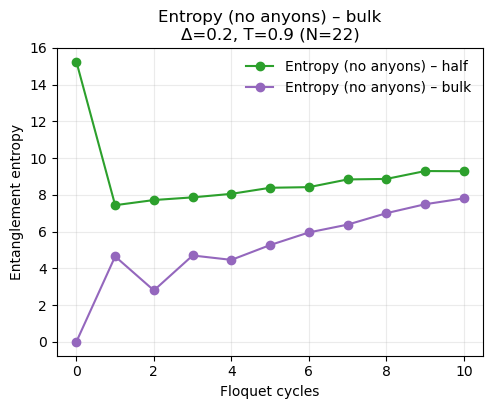

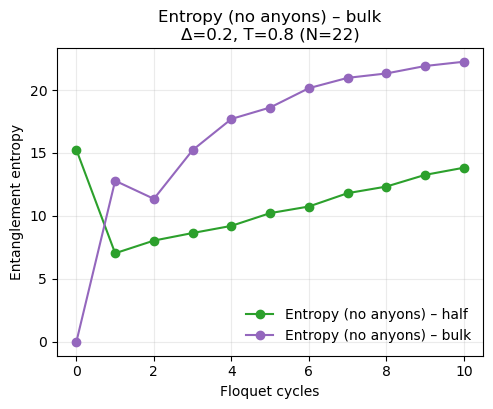

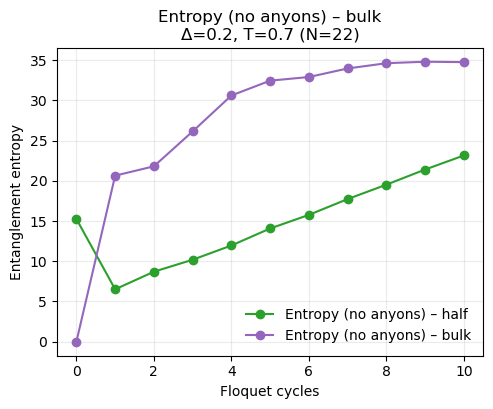

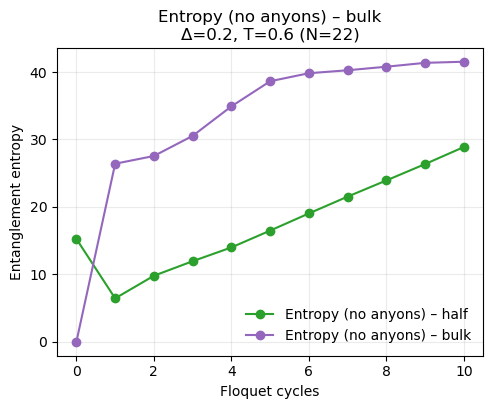

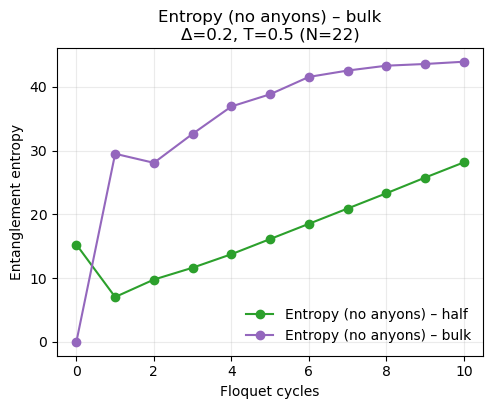

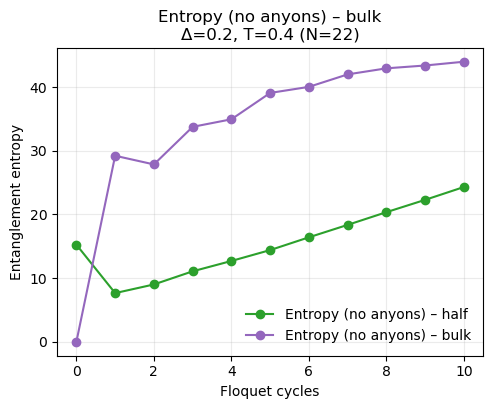

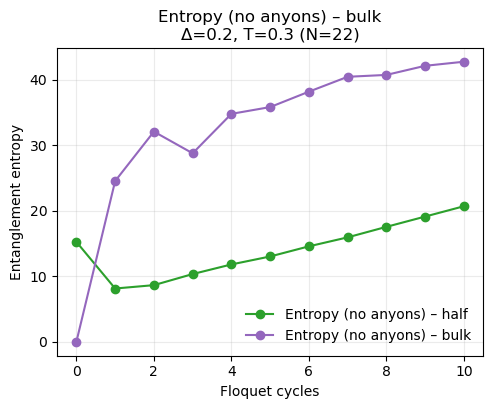

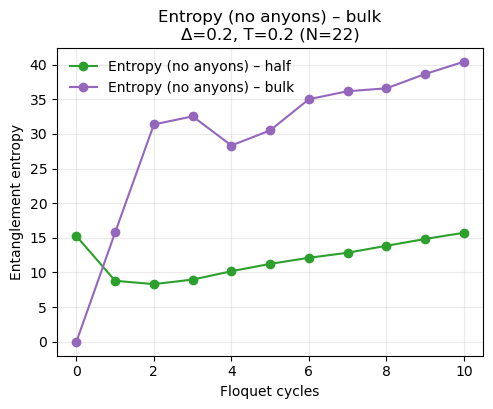

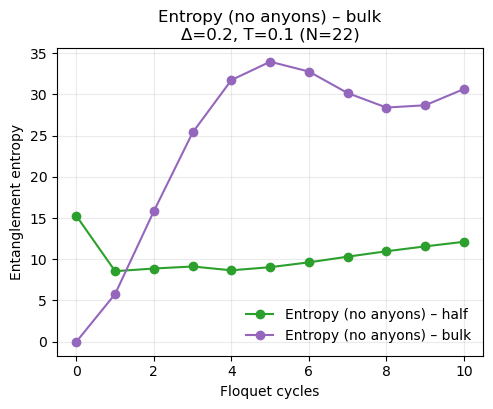

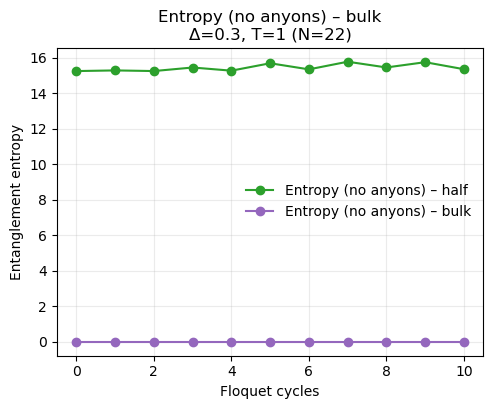

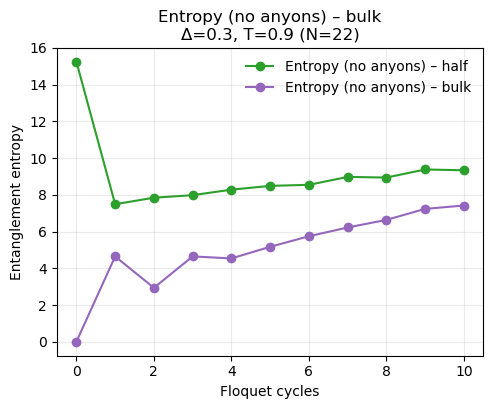

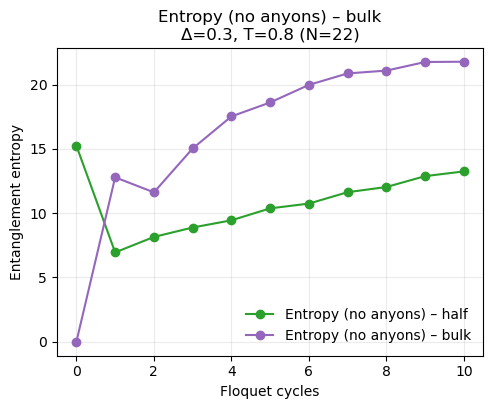

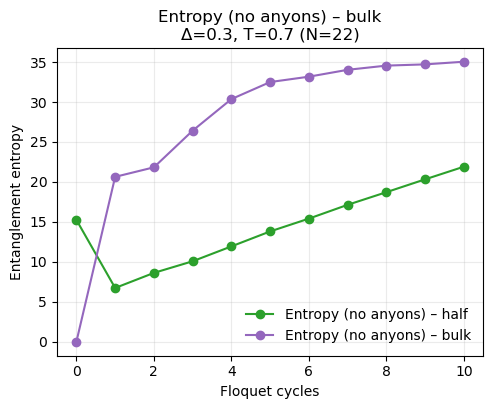

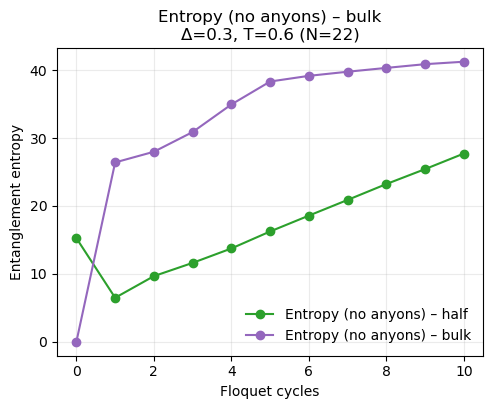

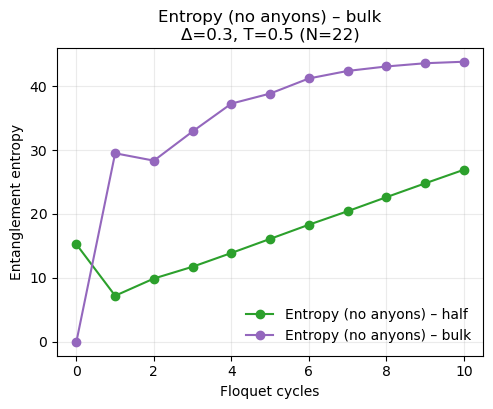

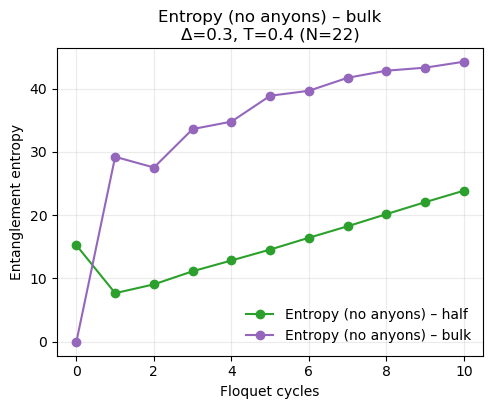

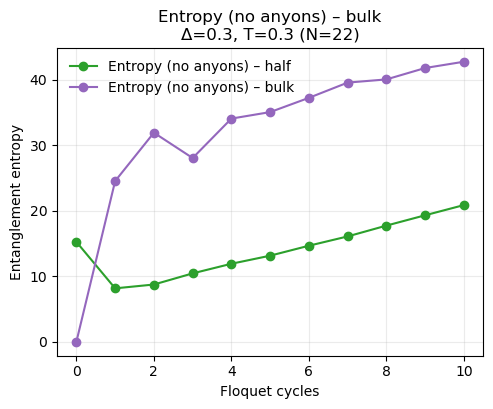

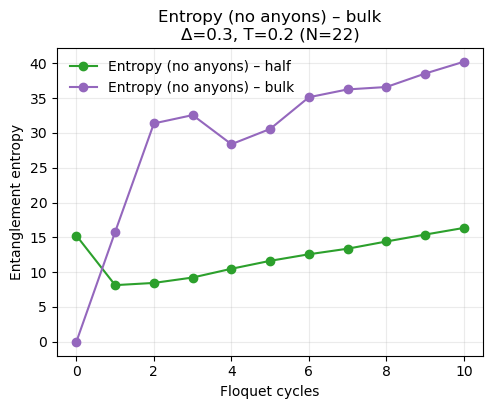

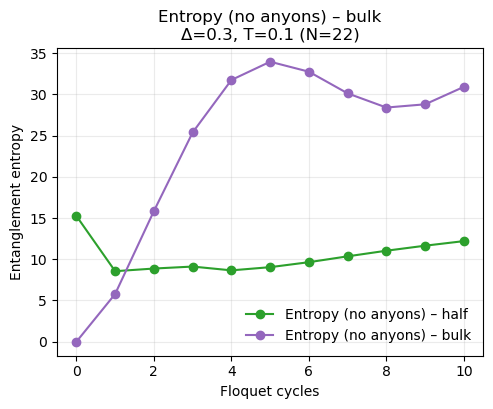

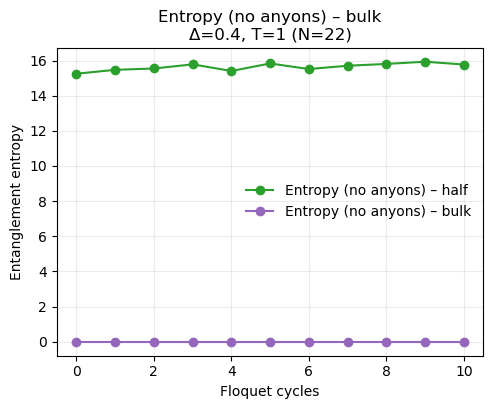

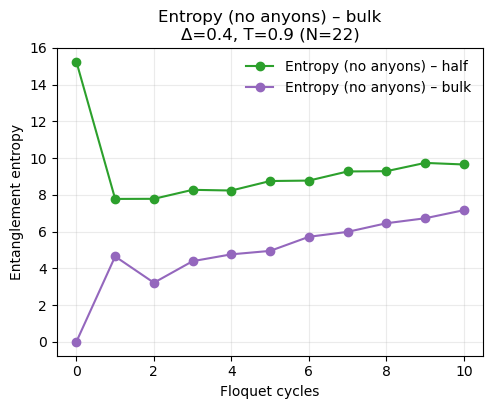

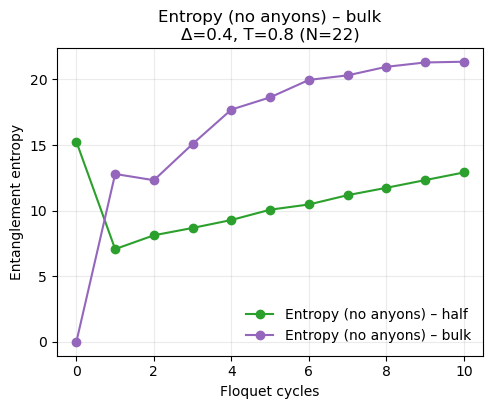

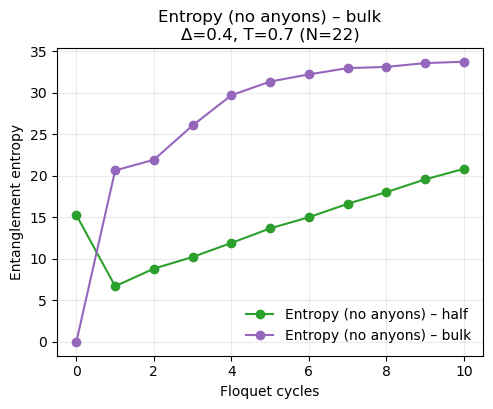

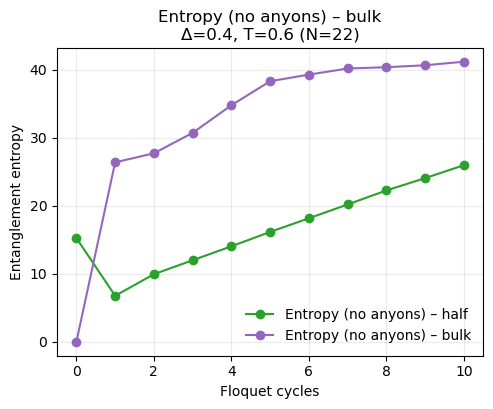

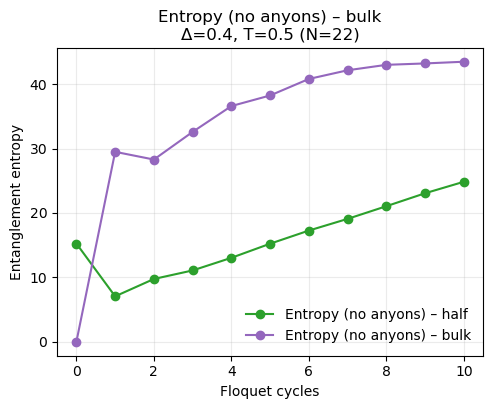

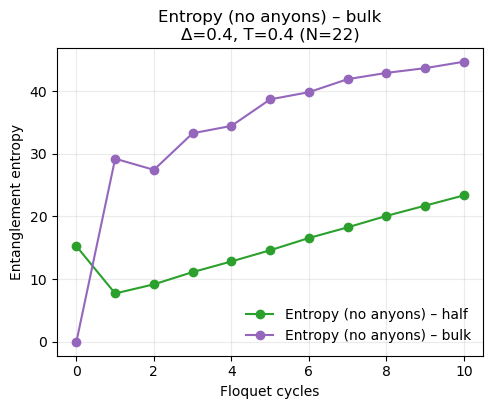

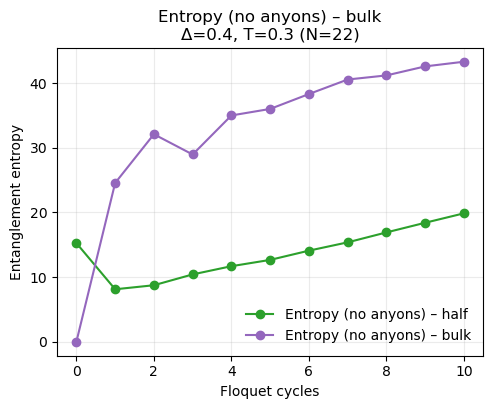

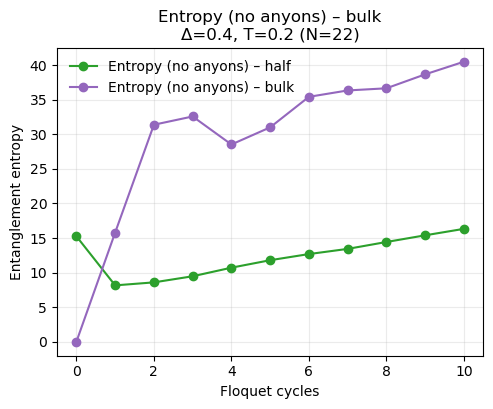

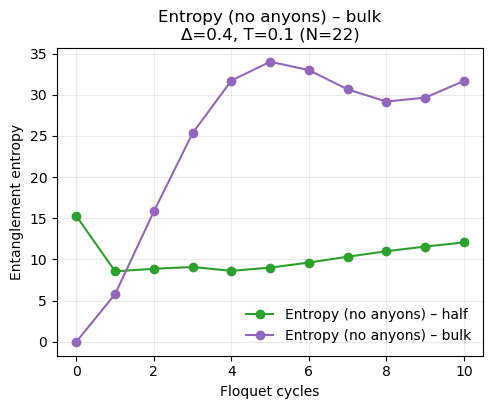

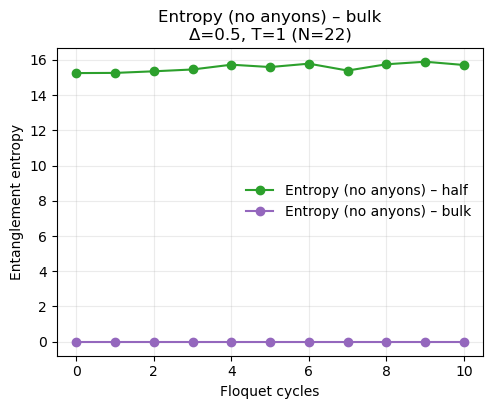

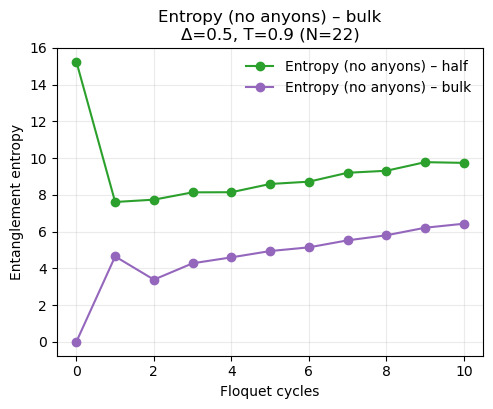

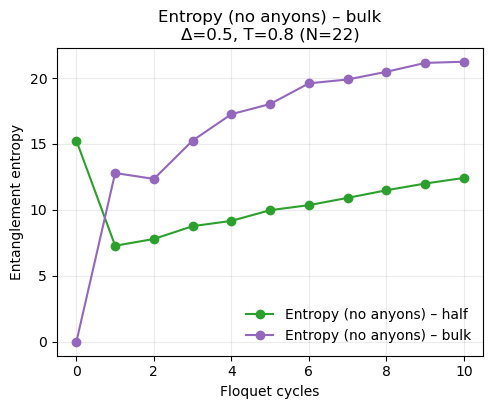

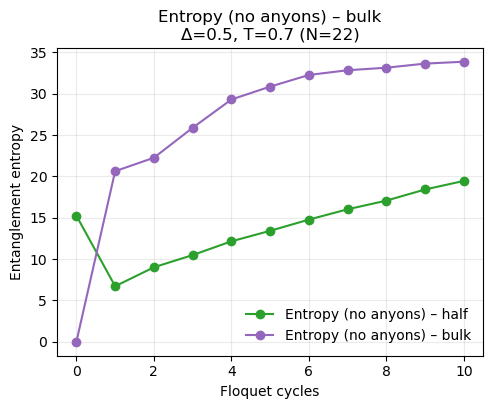

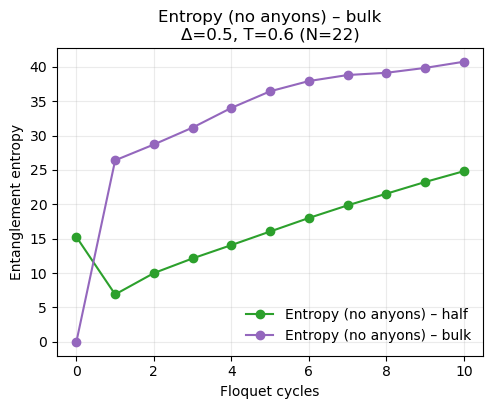

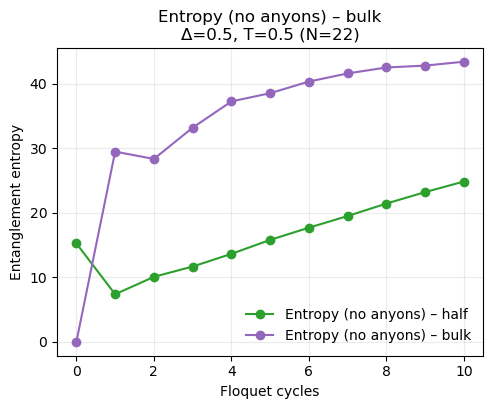

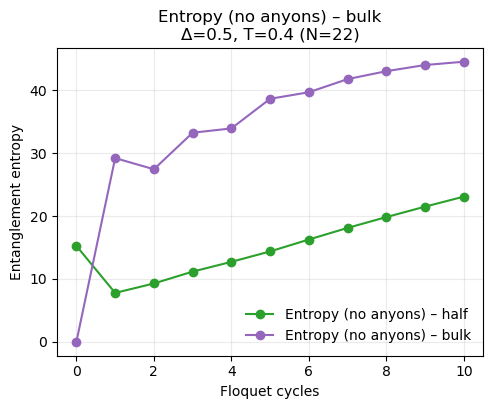

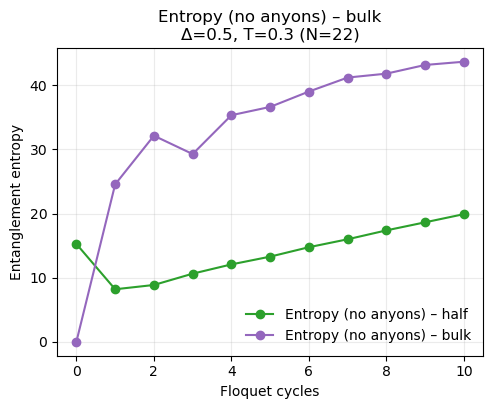

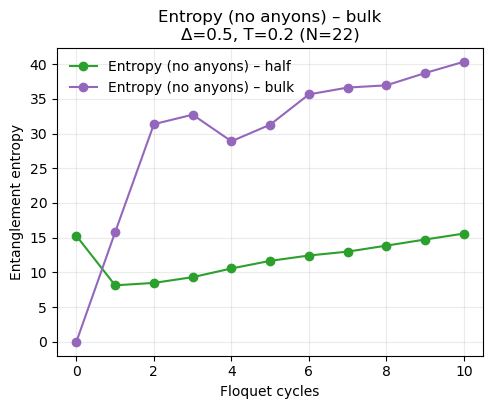

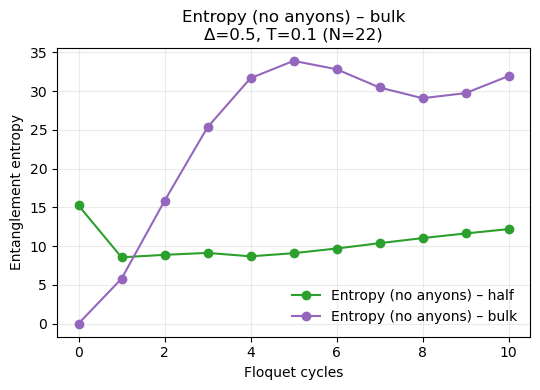

In [ ]:
# create one axes, then plot multiple series on it
for i in range(len(delta_list)):
    for j in range(len(T_list)):
        fig, ax = plt.subplots(figsize=(5.5, 4.0))
        # plot_quantity_vs_cycles(results, delta_list, T_list, i=i, j=j, key='entropy_0', ax=ax, color='C0')
        # plot_quantity_vs_cycles(results, delta_list, T_list, i=i, j=j, key='entropy_e', ax=ax, color='C1')
        plot_quantity_vs_cycles(results, delta_list, T_list, i=i, j=j, key='entropy_0_half', ax=ax, color='C2', color_1='C5')
        plot_quantity_vs_cycles(results, delta_list, T_list, i=i, j=j, key='entropy_0_bulk', ax=ax, color='C4', color_1='C9')
fig.tight_layout()

# Participation ratio

/var/folders/6j/zg3nz4053f97fyqx4w2b6pxc0000gn/T/ipykernel_88605/2095731188.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(5.5, 4.0))


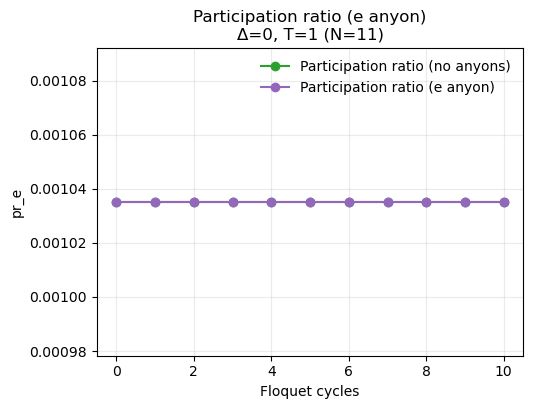

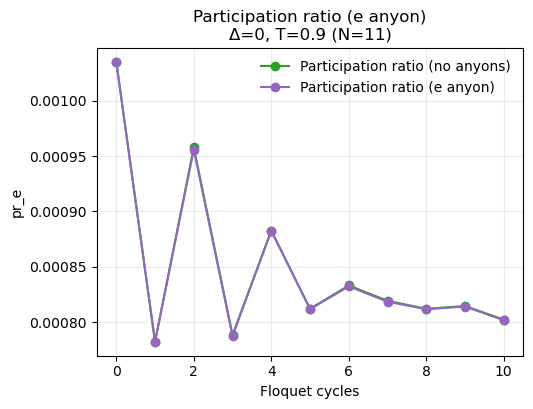

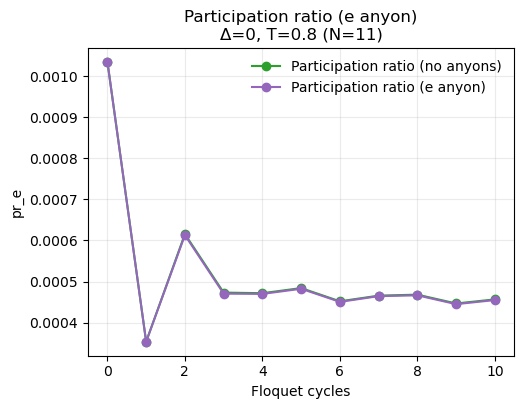

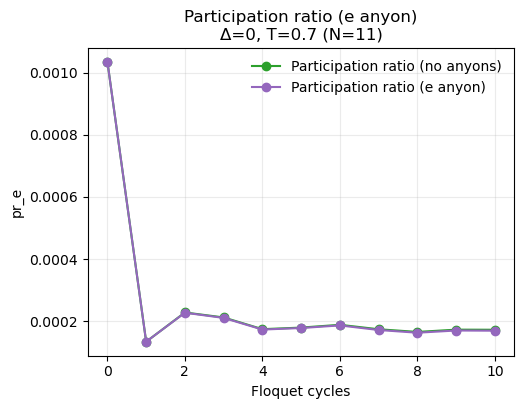

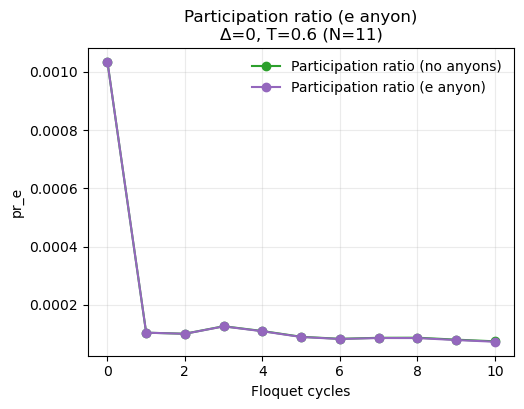

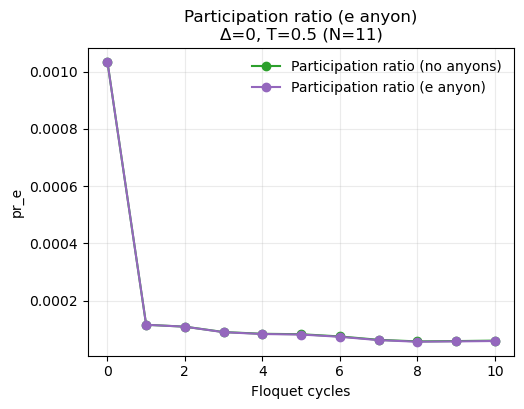

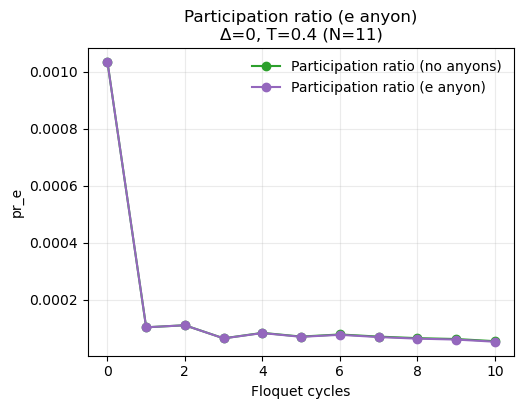

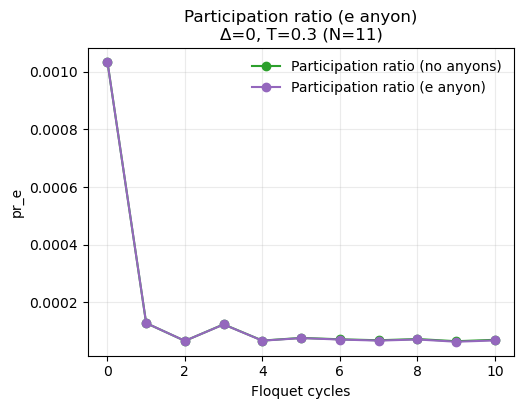

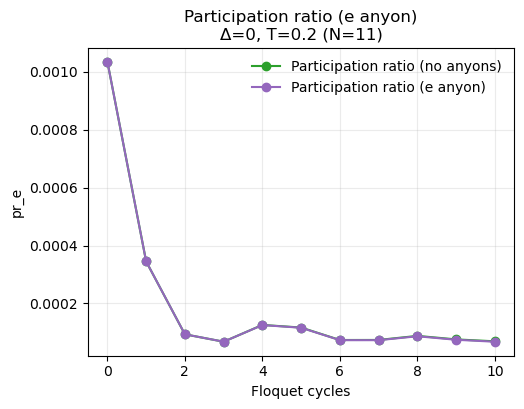

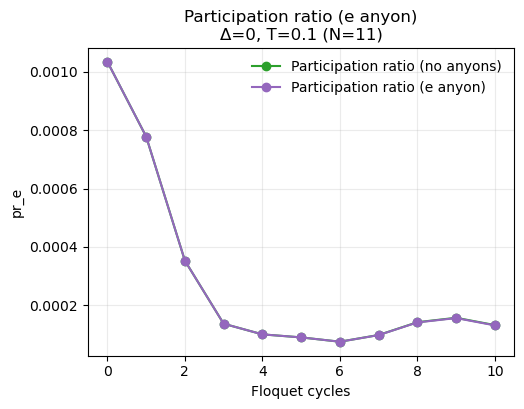

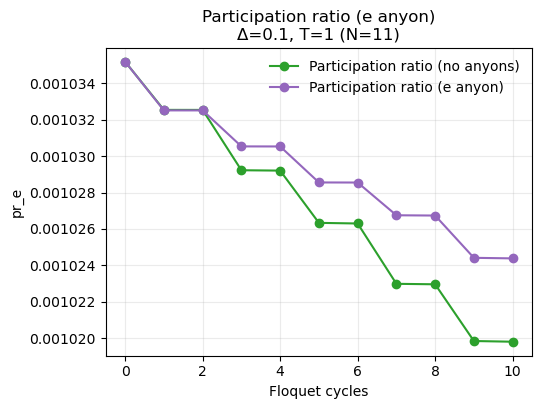

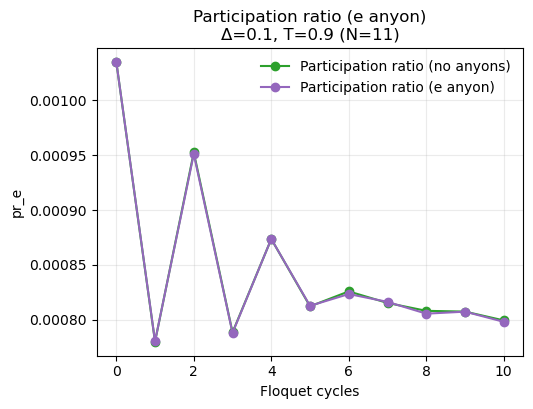

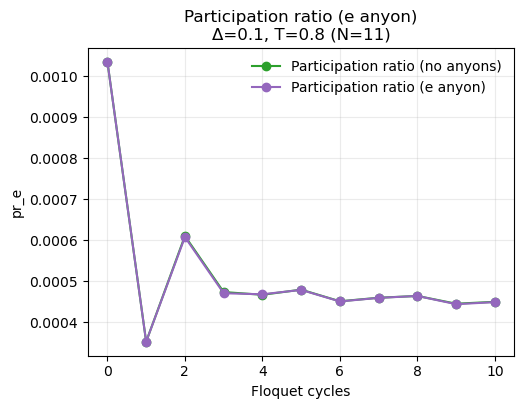

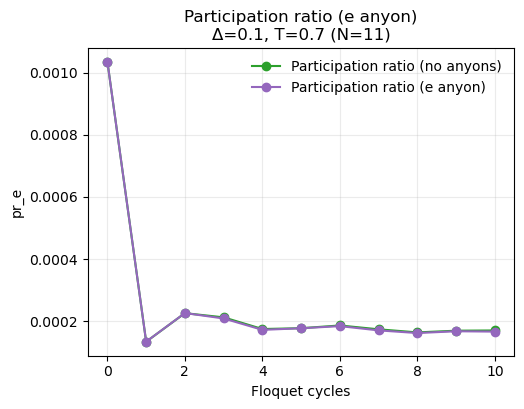

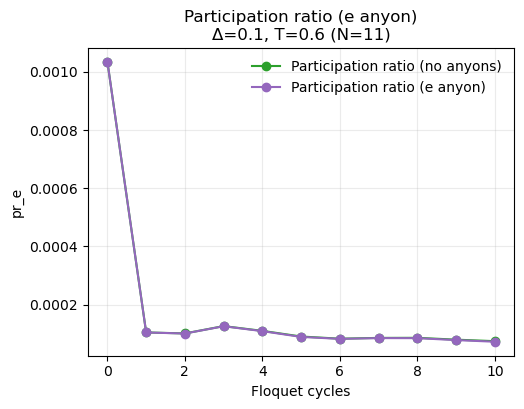

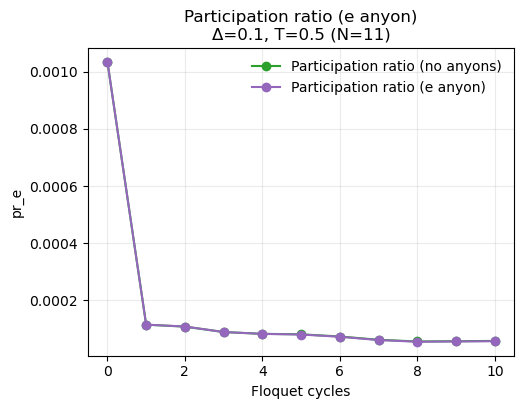

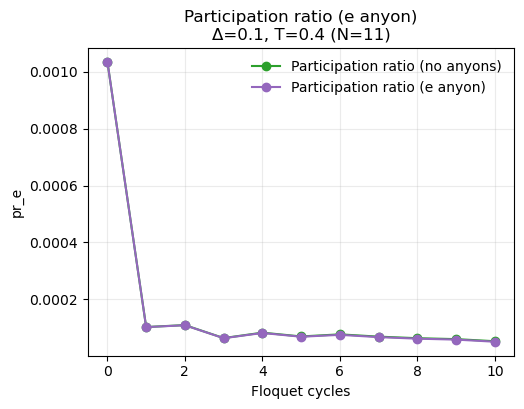

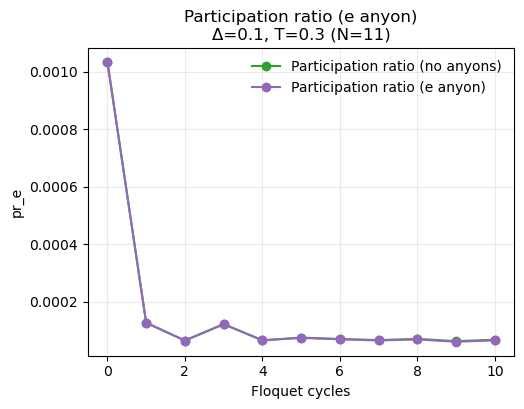

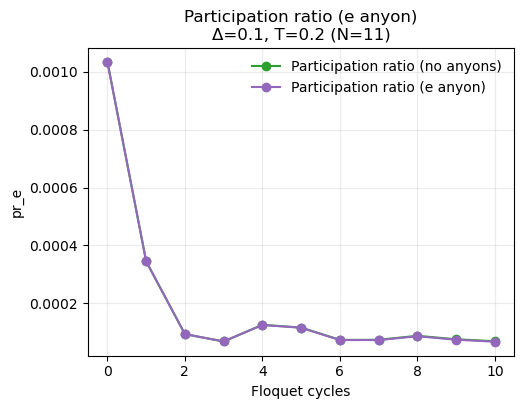

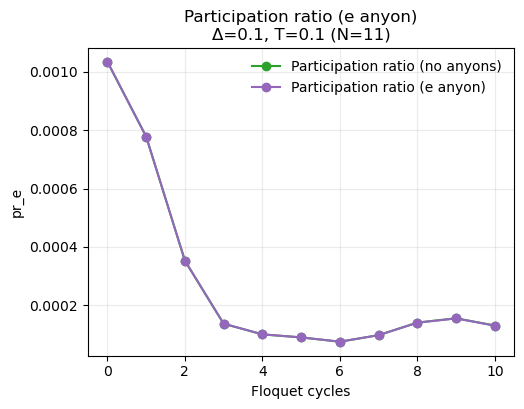

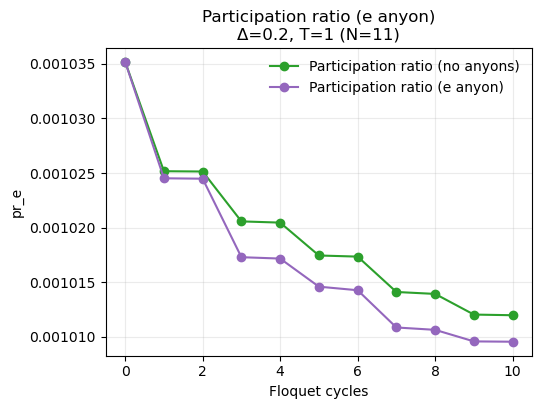

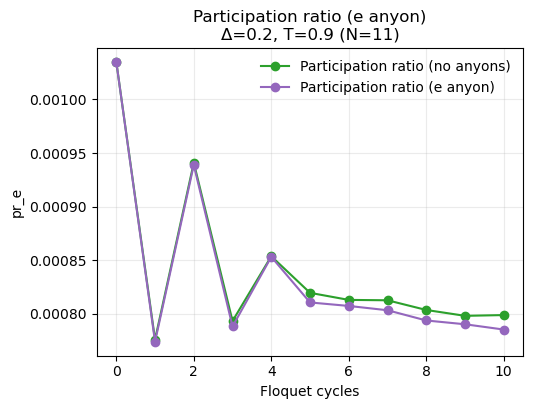

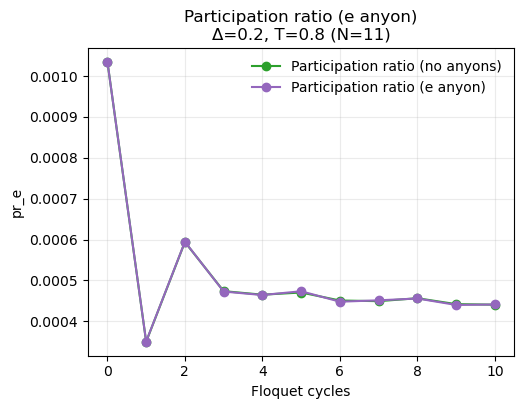

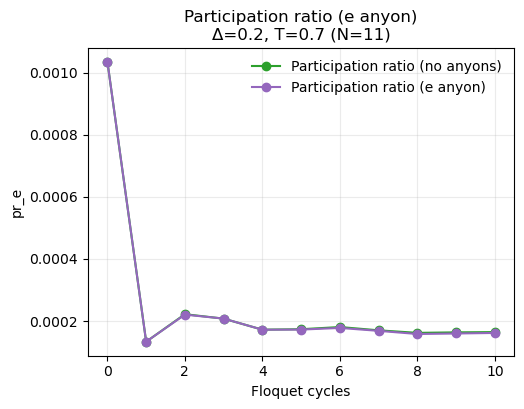

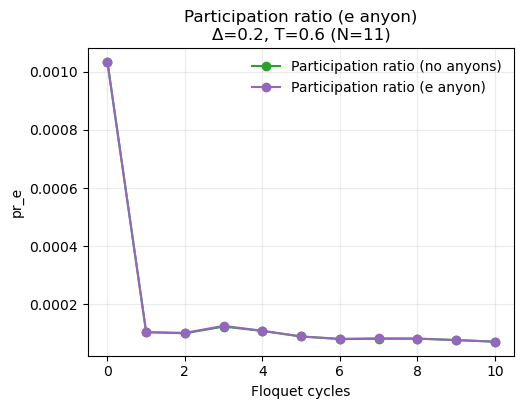

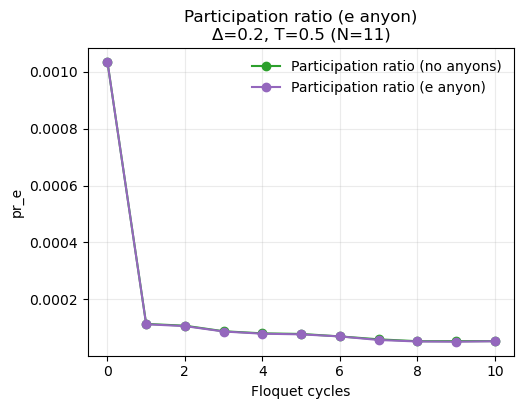

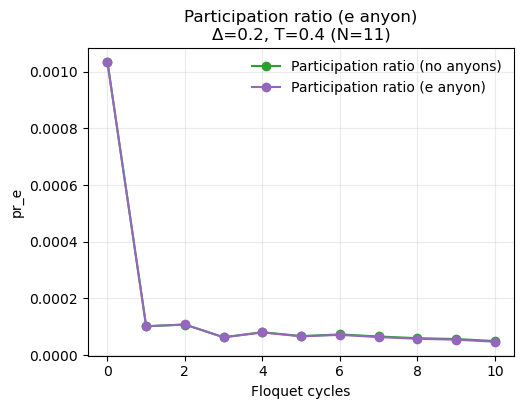

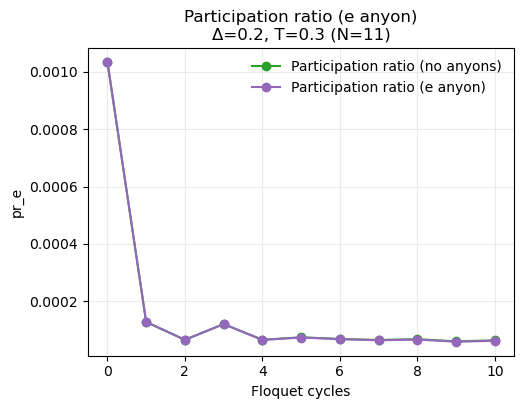

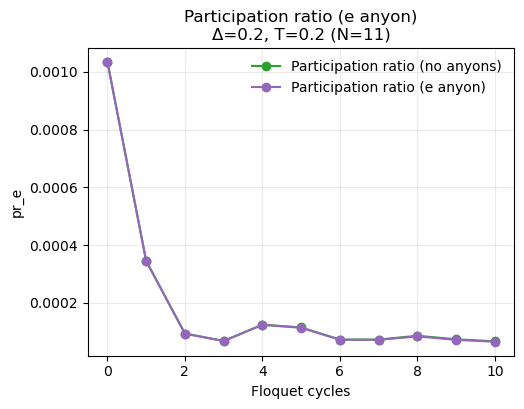

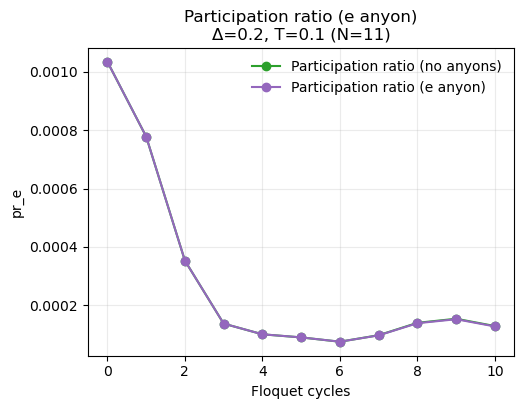

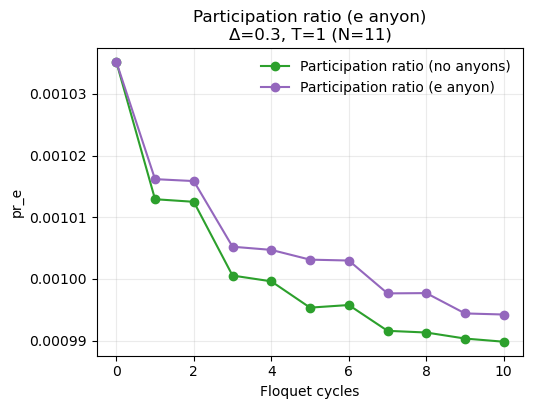

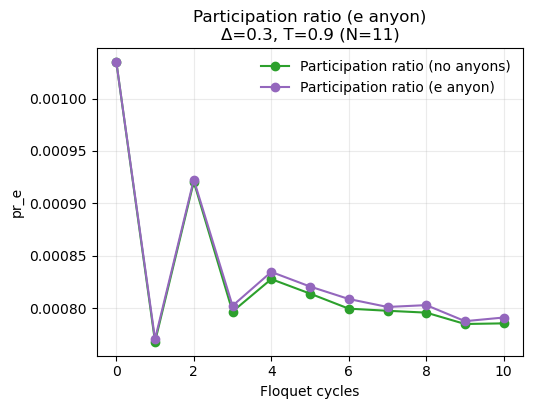

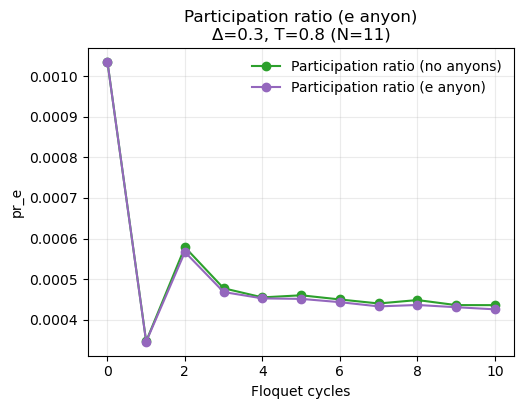

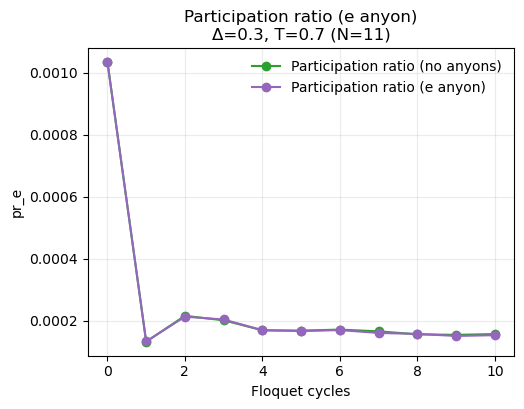

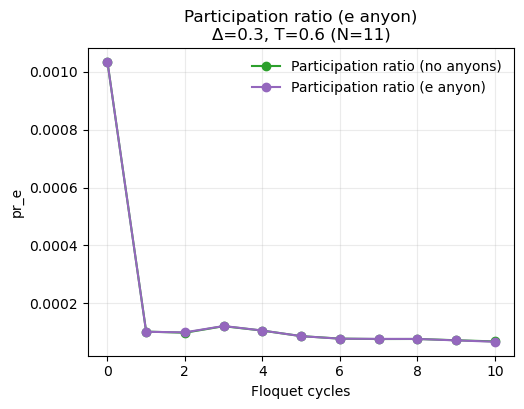

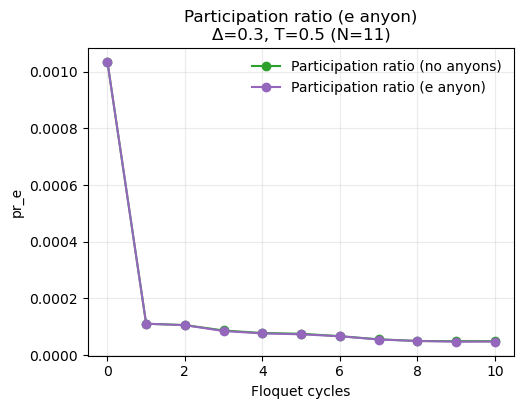

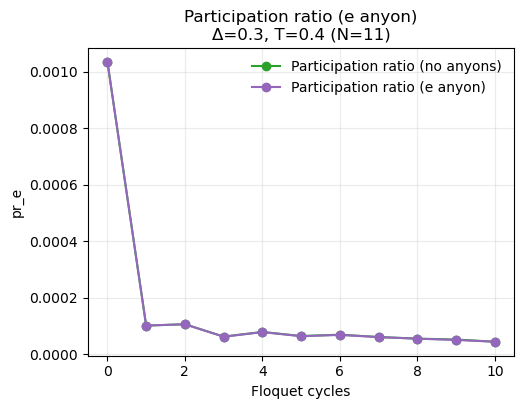

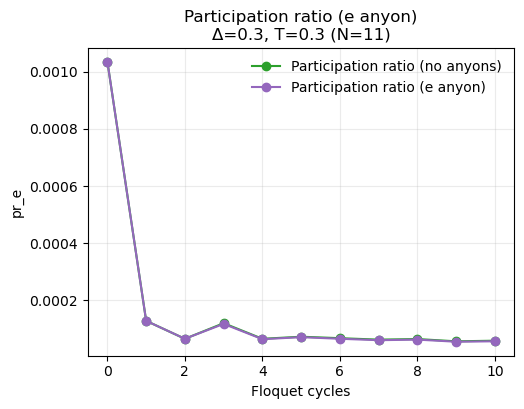

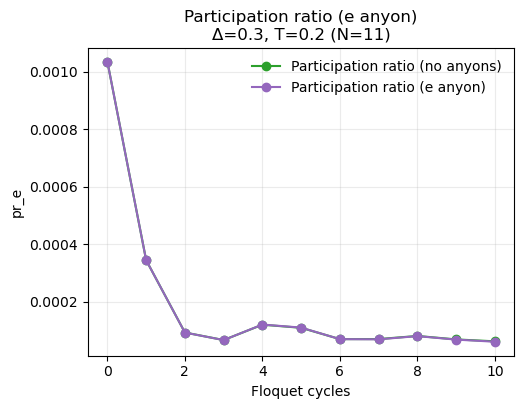

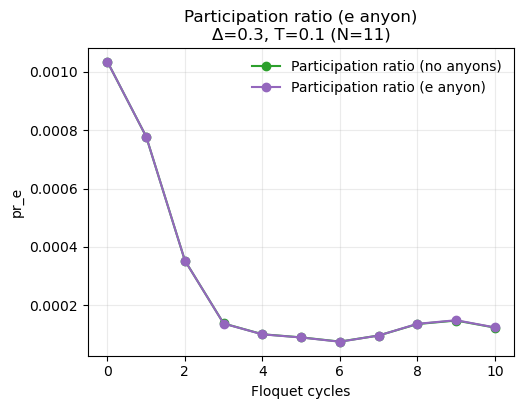

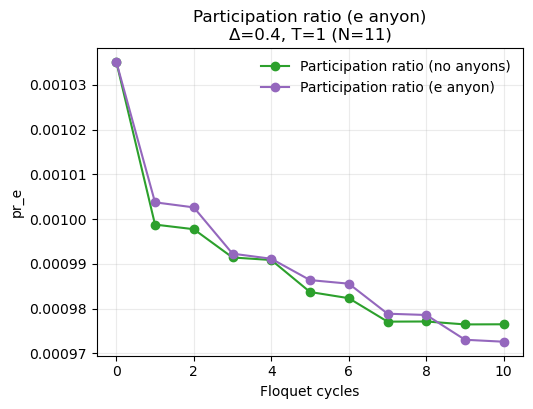

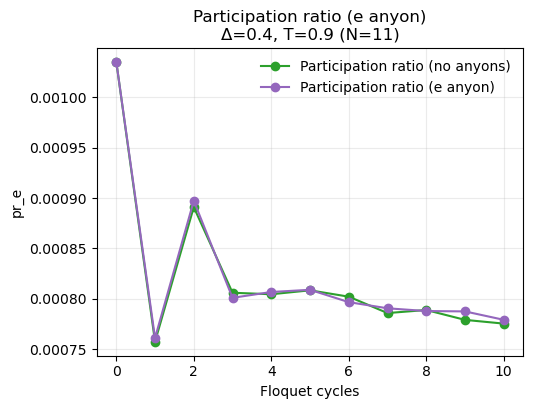

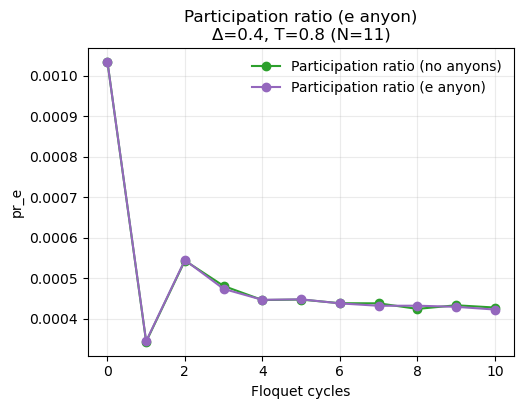

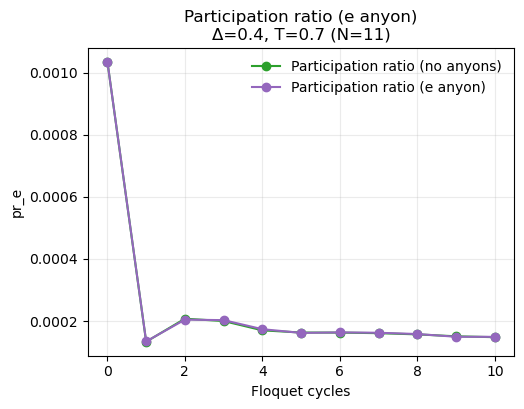

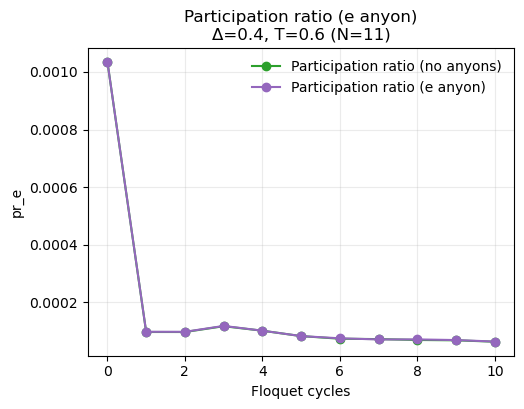

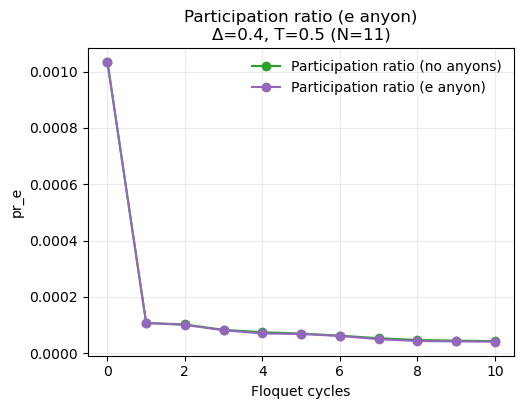

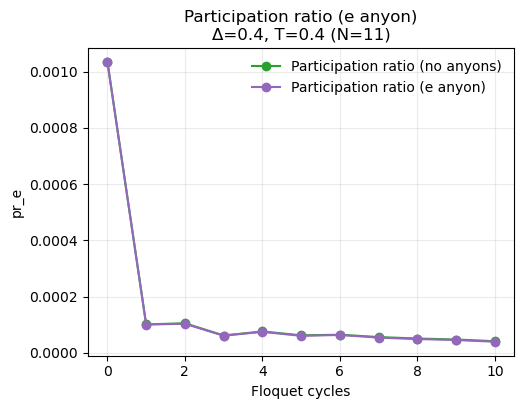

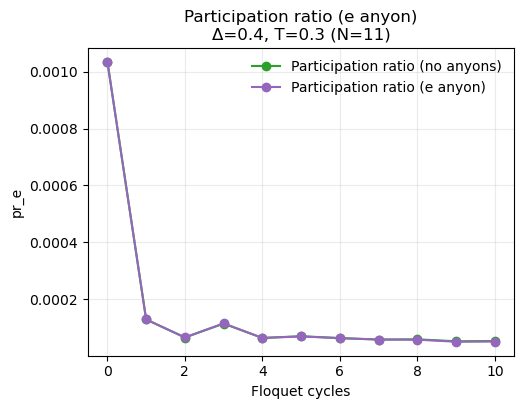

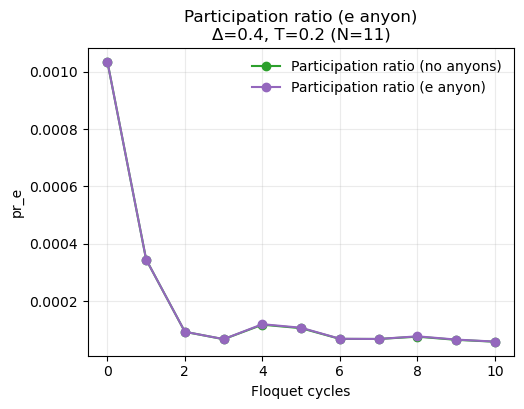

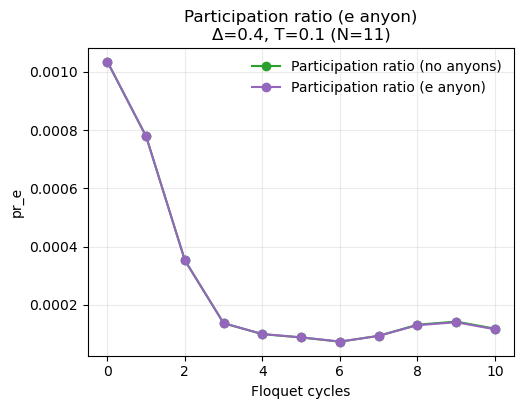

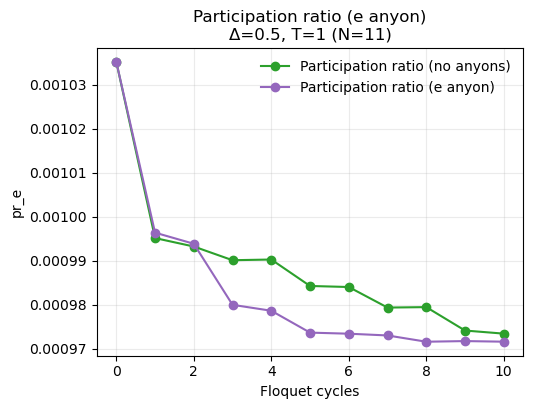

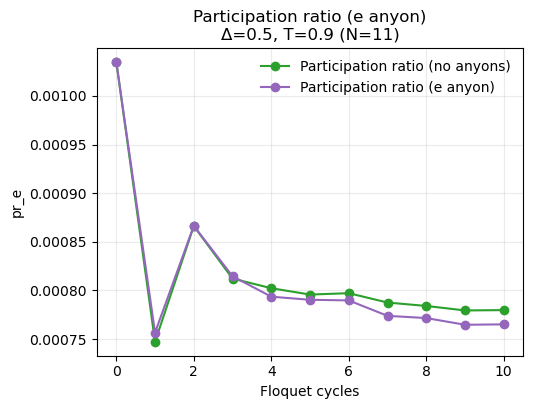

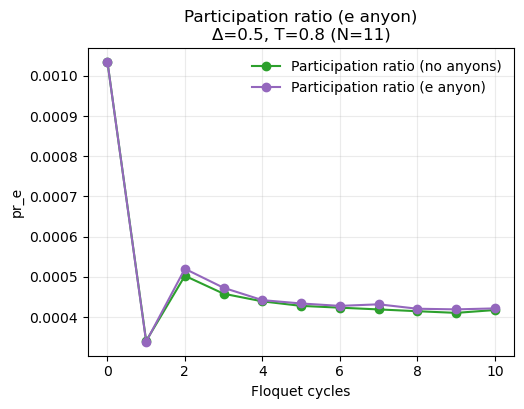

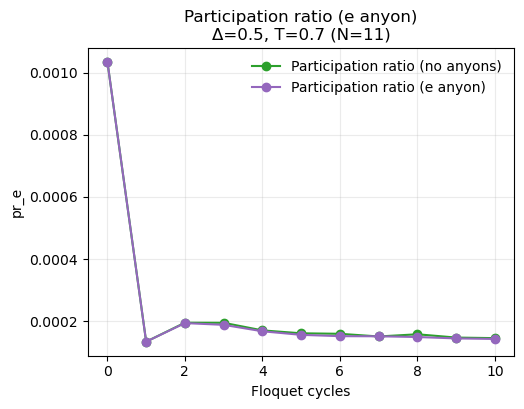

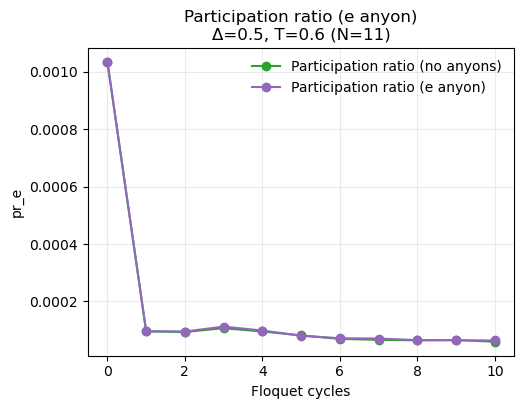

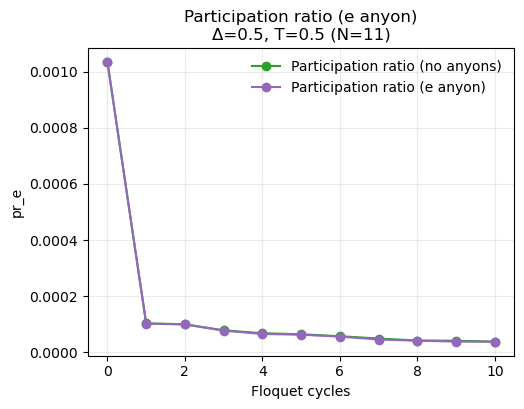

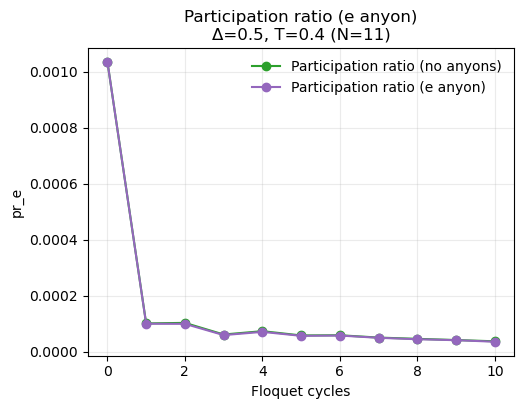

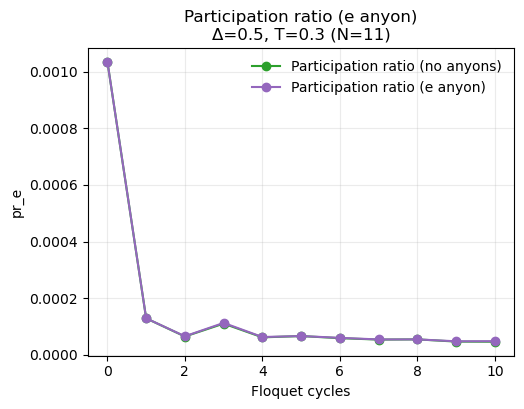

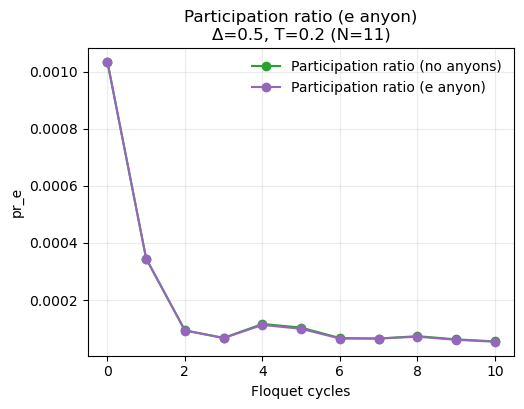

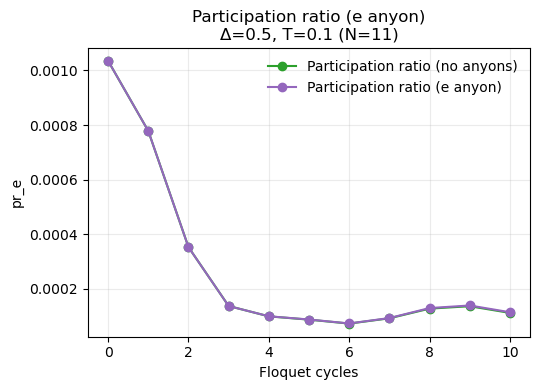

In [84]:
# create one axes, then plot multiple series on it
for i in range(len(delta_list)):
    for j in range(len(T_list)):
        fig, ax = plt.subplots(figsize=(5.5, 4.0))
        # plot_quantity_vs_cycles(results, delta_list, T_list, i=i, j=j, key='entropy_0', ax=ax, color='C0')
        # plot_quantity_vs_cycles(results, delta_list, T_list, i=i, j=j, key='entropy_e', ax=ax, color='C1')
        plot_quantity_vs_cycles(results, delta_list, T_list, i=i, j=j, key='pr_0', ax=ax, color='C2')
        plot_quantity_vs_cycles(results, delta_list, T_list, i=i, j=j, key='pr_e', ax=ax, color='C4')
fig.tight_layout()